# Bazykin's predator-prey ecosystem

This notebook demonstrates initialization of homoclinic orbits emanating form a
generic codimension two Bogdanov-Takens bifurcation point in the following
predator-prey ecosystem

$$
\begin{cases}
\begin{aligned}
\dot x_1 &= x_1 - \frac{x_1 x_2}{1+\alpha x_1} - \epsilon x_1^2, \\
\dot x_2 &= -\gamma x_2 + \frac{x_1 x_2}{1+\alpha x_1} - \delta x_2^2. \\
\end{aligned}
\end{cases}
$$

The variables $x_{1}$ and $x_{2}$ are (scaled) population numbers of prey and
predator, respectively, while $\alpha, \gamma, \varepsilon$, and $\delta$ are
nonnegative parameters describing the behavior of isolated populations and
their interaction, see {cite}`Kuznetsov@2004,Bazykin@1985`

## Overview

In this demo we will

- Define an analytically derived Bogdanov-Takens point.
- Start continuation of the homoclinic branch emanating from the
  Bogdanov-Takens point in two parameters $(d,h)$ using the new homoclinic
  smooth orbital predictor from {cite}`Bosschaert@2021`.
- Compare the predicted and computed homoclinic bifurcation curve emanating from the
  Bogdanov-Takens point in parameters space.
- Compare a range of predictors for the homoclinic solutions emanating from the
  Bogdanov-Takens point with the corrected homoclinic solutions curve in
  phase-space.
- Create a convergence plot of the different homoclinic approximations
  derived in {cite}`Bosschaert@2021`.

## Load MatCont

Before we can start using __MatCont__ we need to add the main directory of
__MatCont,__ as well as various subdirectories of __MatCont,__ to the _MATLAB
search path_. This is done in the code below. The variable `matcont_home`
should point to the main directory of __MatCont.__

In [10]:
clear all
matcontpath = '../';
addpath(matcontpath)
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'LimitPointCycle'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'Utilities'])
set(groot, 'defaultTextInterpreter', 'LaTeX');

## Set the odefile

Next we set the variable `odefile` to the _system file_ previously generated by
the notebook [](BazykinGenSym.ipynb).

In [11]:
odefile=@Bazykin;

## Define Bogdanov-Takens point manually

It is easy to analytically derive a Bogdanov-Takens point at 

```{math}
(x_1, x_2) \approx (6.265765528962353, 3.601553936836365),
```

with parameter values $(\alpha, \delta) \approx (0.4536243277781295, 0.1751275929502174)$.

In [12]:
bt.x = [6.265765528962353; 3.601553936836365];
bt.par = [0.4536243277781295; 0.1751275929502174];

To refer to the parameters throughout the script we create a __cell array__ of
strings containing the parameter names. This is then converted into a
__struct__. This allows us to refer to the parameters as `ind.parametername`,
similar as done in _DDE-BifTool_.

In [13]:
parnames = {'alpha', 'delta'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});
ap = [ind.alpha ind.delta]; % continuation parameters

## Continue homoclinic curve emanating from Bogdanov-Takens point

To continue the homoclinic curve emanating from the Bogdanov-Takens point we
use the functions `BT_Hom_set_options` and `init_BT_Hom` to obtain an initial
approximation to the homoclinic solution (`hom_x`) as well as a tangent vector
to the discretized homoclinic solution (`hom_v`) as described in
{ref}`initial-prediction-Homoclinic-orbit`. 

In [14]:
opt = contset;
opt.Singularities = 0;
opt.MaxNumPoints = 300;
opt.MaxStepsize = 1;
options = BT_Hom_set_options();
[hom_x, hom_v] = init_BT_Hom(odefile, bt,  ap, options);
homoclinic_br = cont(@homoclinic, hom_x, hom_v, opt);

Center manifold coefficients' accuracy: 2.664535e-15
BT normal form coefficients:
a=3.945309e-02,	 b=-5.253878e-02
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 0.857576
The initial half-return time T: 55.2395
The initial distance eps0: 0.00153522
The initial distance eps1: 0.000472271
first point found
tangent vector to first point found

elapsed time  = 11.4 secs
npoints curve = 300


## Compare predicted with computed parameters

Now that we have obtained a curve of homoclinic orbits (`homoclinic_br`) we
compare the computed curve in parameter space with the predicted curve we
construct below. To do so, we use the function `BT_nmfm_orbital` to obtain the
parameter-dependent normal form coefficients and the coefficients between the
parameters of the system and the parameters on the center manifold, see
{cite}`Bosschaert@2021`.

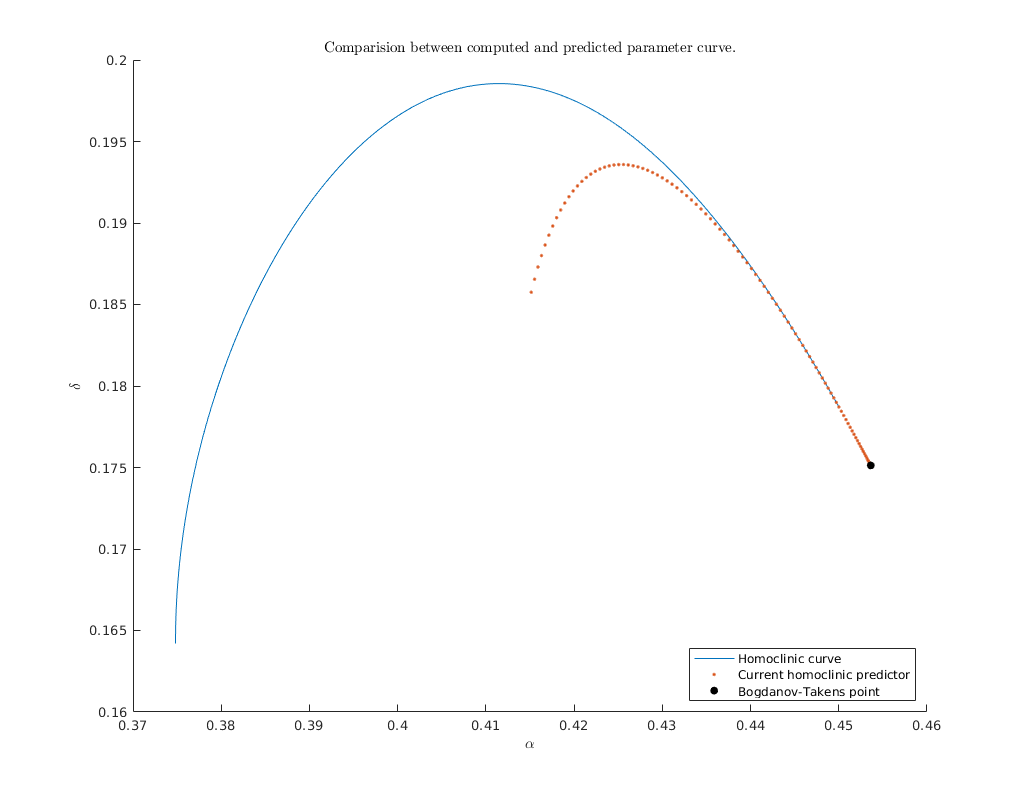

In [22]:
%plot --width 1024 --height 800
hold on
global homds
% plot computed parameter curve
plot(homoclinic_br(homds.PeriodIdx+1,:), ...
     homoclinic_br(homds.PeriodIdx+2,:));
% Bogdanov-Takens parameter-dependent normal form coefficients
bt = BT_nmfm_orbital(odefile, bt, ap, BToptions);
a   = bt.nmfm.a;
b   = bt.nmfm.b;
K10 = bt.nmfm.K10;
K01 = bt.nmfm.K01;
K02 = bt.nmfm.K02;
K11 = bt.nmfm.K11;
K03 = bt.nmfm.K03;
% construct predictor as in the paper
eps = linspace(0, 0.4);
beta1 = -4*a^3/b^4*eps.^4;
tau0  = 10/7;
tau2  = 288/2401;
beta2 = a/b*(tau0 + tau2*eps.^2).*eps.^2;
alpha = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2 + 1/6*K03.*beta2.^3;
alpha = bt.par(ap) + alpha;
% plot currect predictor
plot(alpha(1,:), alpha(2,:), '.')
% plot Bogdanov-Takens point
plot(bt.par(ind.alpha), bt.par(ind.delta), '.k', 'MarkerSize', 20)
% set axis labels and legend
xlabel('$\alpha$')
ylabel('$\delta$')
legend({'Homoclinic curve', 'Current homoclinic predictor', ...
    'Bogdanov-Takens point'}, 'Location', 'SouthEast')
%axis([1.1334    1.1658    0.6305    0.7339])
title('Comparision between computed and predicted parameter curve.')

## Bifurcation diagram in phase-space $(x_1,x_2)$

To obtain an impression of the  homoclinic solutions we plot the computed
homoclinic orbits in $(x,y)$ phase-space.

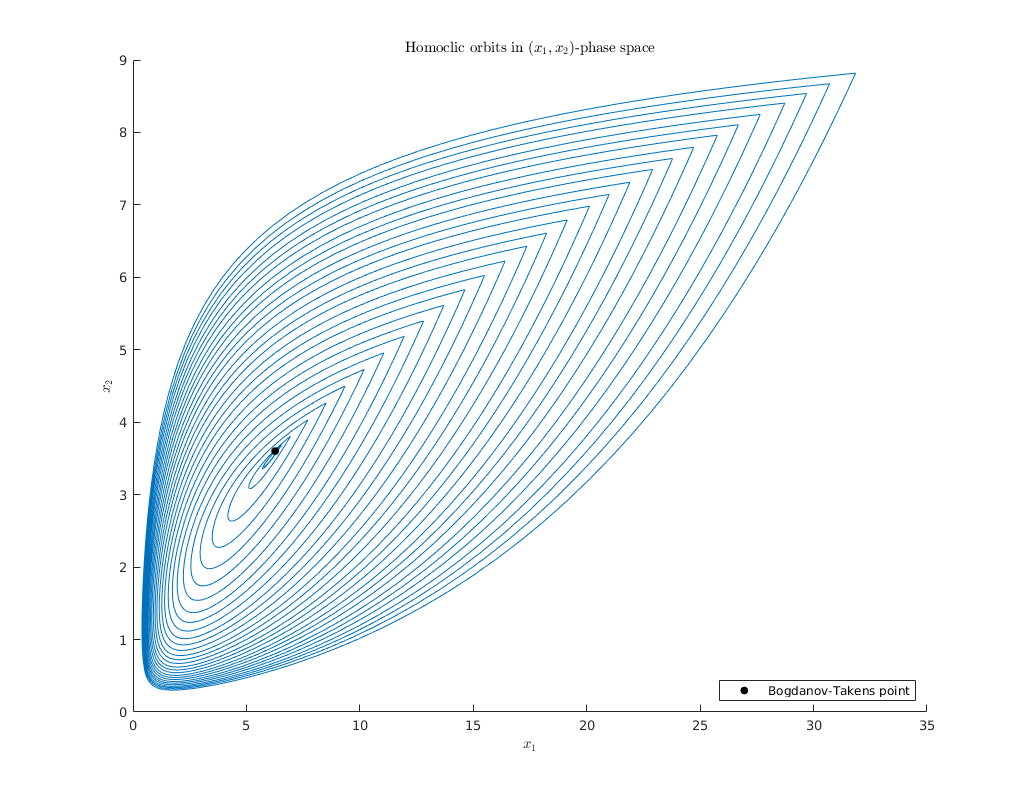

In [16]:
hold on
plot(homoclinic_br(homds.coords(1:homds.nphase:end), 1:10:end), ...
     homoclinic_br(homds.coords(2:homds.nphase:end), 1:10:end), ...
     'Color', [0 0.4470 0.7410], 'HandleVisibility', 'Off')
xlabel('$x_1$')
ylabel('$x_2$')
plot(bt.x(1), bt.x(2), '.k' ,'MarkerSize', 20)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(x_1,x_2)$-phase space')

### Predictors of orbits for various epsilons

Below we compute for a large range of amplitudes the predicted and corrected
homoclinic solutions and compare them in phase space. We see that even with an
amplitude of `2` the predicted homoclinic orbit is still very close.

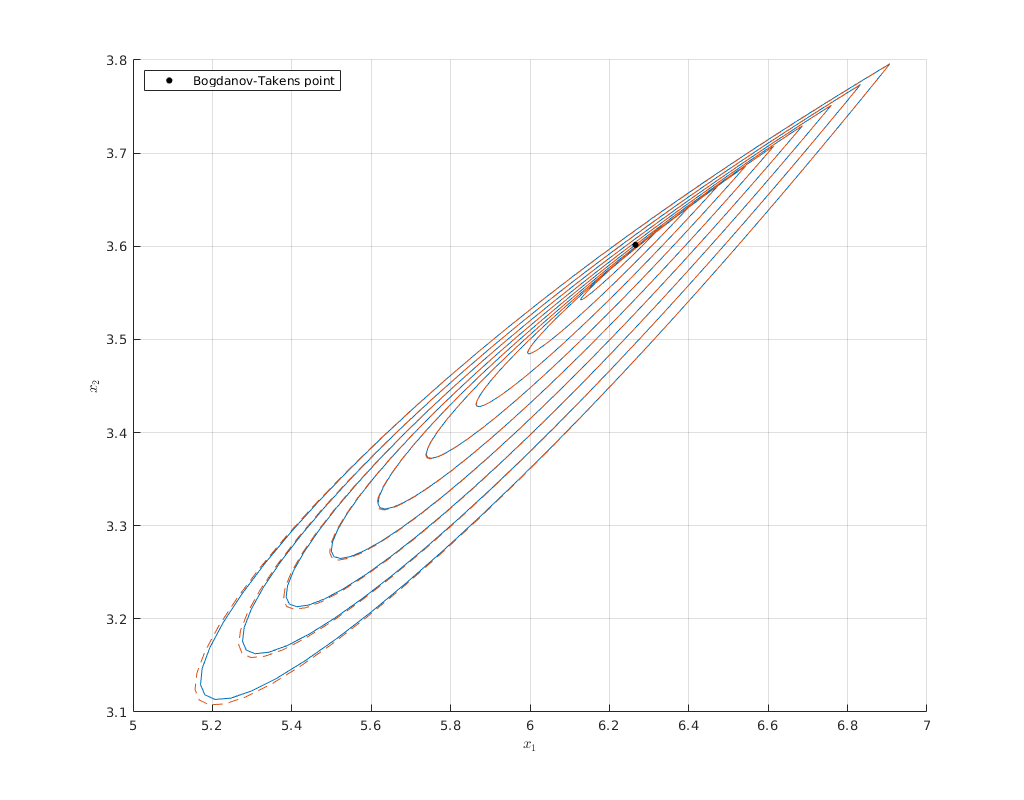

In [17]:
options = BT_Hom_set_options();
options.messages = false;
options.correct = false;
options.TTolerance = 1.0e-05;

amplitudes = linspace(1.0e-03, 2,10);
XPredicted = zeros(330,length(amplitudes));
XCorrected = zeros(330,length(amplitudes));
for j=1:length(amplitudes)
  options.amplitude = amplitudes(j);
  [x_pred, v0] = init_BT_Hom(odefile, bt, ap, options);
  XPredicted(:,j) = x_pred;
  try
    XCorrected(:,j) = newtcorr(x_pred, v0);
  catch
    warning('Didn''t convergence to homoclinic solution')
  end
end

hold on
cm = lines;
plot(XPredicted(homds.coords(1:homds.nphase:end),1:10), ...
     XPredicted(homds.coords(2:homds.nphase:end),1:10), ...
      'color', cm(1,:), 'HandleVisibility', 'Off')
plot(XCorrected(homds.coords(1:homds.nphase:end),1:10), ...
     XCorrected(homds.coords(2:homds.nphase:end),1:10), ...
      '--', 'color', cm(2,:), 'HandleVisibility', 'Off')
plot(bt.x(1), bt.x(2), '.k', 'MarkerSize', 16)
xlabel('$x_1$')
ylabel('$x_2$')
legend('Bogdanov-Takens point', 'Location', 'NorthWest')
grid on

## Convergence plot

We finish this notebook with a log-log convergence plot comparing the different
third order homoclinic approximation methods derived in {cite}`Bosschaert@2021`
to approximate the homoclinic solutions near the first Bogdanov-Takens point.
On the abscissa is the amplitude $A_0$ and on the ordinate the relative error
$\delta$ between the constructed solution (`x_pred`) to the defining system for the
homoclinic orbit and the Newton corrected solution (`x_corrected`).

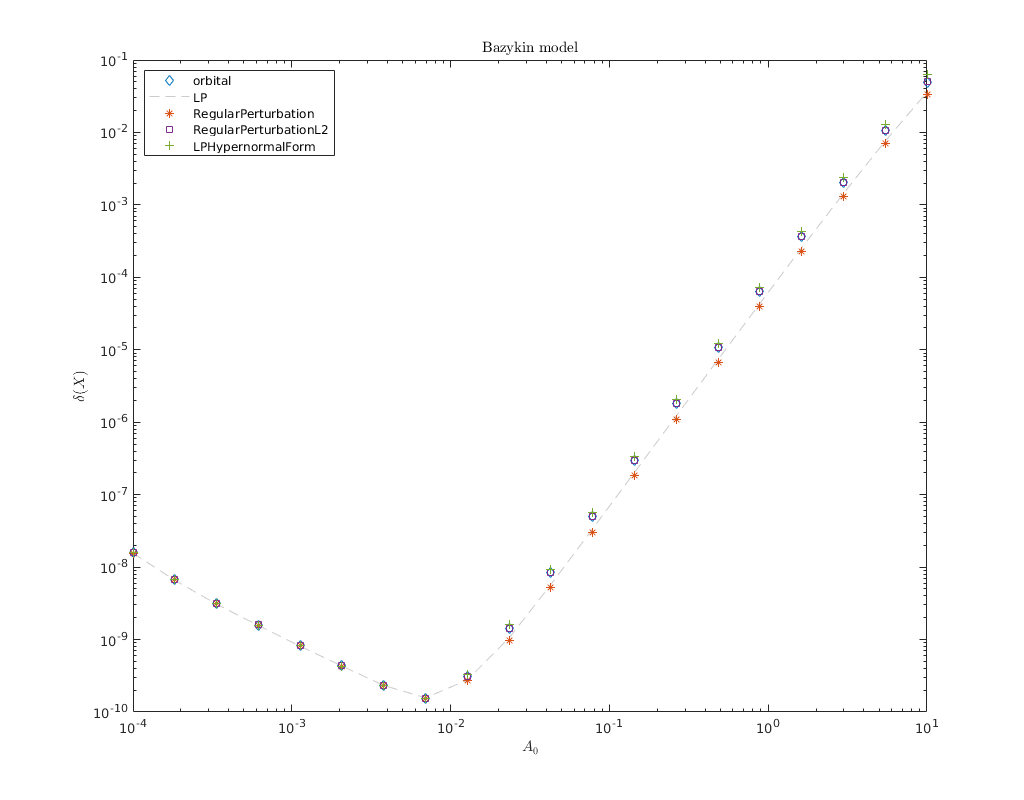

In [18]:
BToptions = BT_Hom_set_options();
BToptions.TTolerance = 1e-05;
BToptions.messages = false;
BToptions.correct = false;

amplitudes = logspace(-4, 1, 20);
methodList = {'orbital', 'LP', 'RegularPerturbation', ...
    'RegularPerturbationL2', 'LPHypernormalForm'};
relativeErrors = {};
for i=1:length(methodList)
    BToptions.method = methodList{i};
    relativeErrors{i} = zeros(size(amplitudes));
    for j=1:length(amplitudes)
    BToptions.amplitude = amplitudes(j);
    [x_pred, v0] = init_BT_Hom(odefile, bt, ap, BToptions);
    try
        x_corrected = newtcorr(x_pred, v0);
        relativeErrors{i}(j) = norm(x_corrected-x_pred)/norm(x_corrected);
    catch
        warning('Did not converge.')
        continue
    end
  end
end

cm = lines();
loglog(amplitudes, relativeErrors{1}(:), 'd', ...
       amplitudes, relativeErrors{2}(:), '--', ...
       amplitudes, relativeErrors{3}(:), '*', ...
       amplitudes, relativeErrors{4}(:), 's', ...
       amplitudes, relativeErrors{5}(:), '+')
legend(methodList, 'Location', 'NorthWest')
title('Bazykin model')
xlabel('$A_0$')
ylabel('$\delta(X)$')
ax = gca;
ax.ColorOrder = [cm(1,:); [0.8 0.8 0.8]; cm(2,:); cm(4,:); cm(5,:)];